In [138]:
import pandas as pd

data = pd.read_csv('daily_ridership.csv', header=0, parse_dates=['service_date'], index_col='service_date')
data.drop('total_rides', axis=1, inplace=True)
data.drop_duplicates(inplace=True)
data.columns = ['day_type', 'bus', 'rail']
data = data.asfreq('D')
data = data[:'2019']
data

,day_type,bus,rail
service_date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2019-12-27,W,552198,445835
2019-12-28,A,394869,298646
2019-12-29,U,315428,251105


In [306]:
period = slice("2019-03-01", "2019-05-31")

<AxesSubplot: xlabel='service_date'>

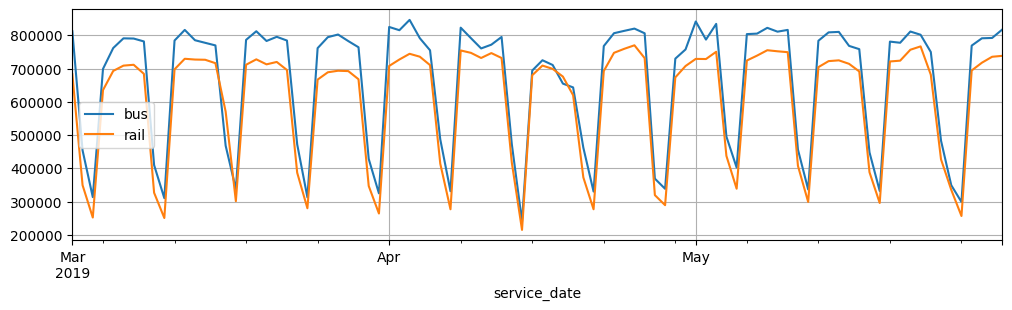

In [307]:
data[['bus', 'rail']].loc[period].plot(figsize=(12, 3), grid=True)

There is a clear weekly seasonality (as expected for ridership)

<AxesSubplot: xlabel='service_date'>

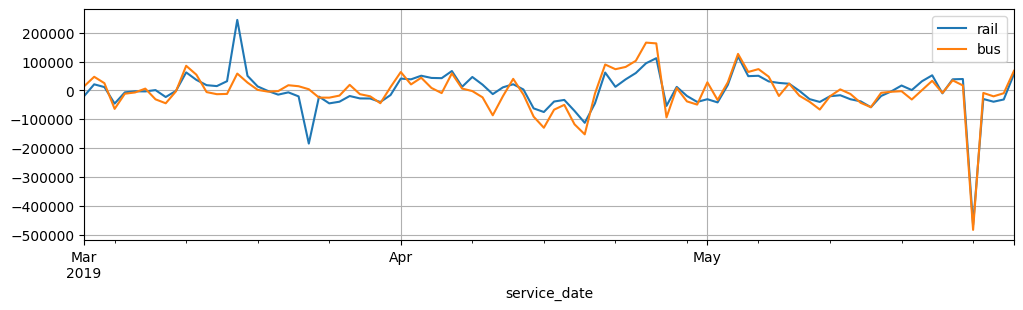

In [308]:
data[['rail', 'bus']].diff(7).loc[period].plot(figsize=(12, 3), grid=True)

## Baseline Forecast Error (where the actuals is the value from last week)

In [309]:
# MAE
diff_7 = data[['bus', 'rail']].diff(7).loc[period]
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [310]:
# MAPE
(diff_7.abs() / data[['bus', 'rail']].loc[period]).mean() * 100

bus     8.293847
rail    8.994765
dtype: float64

In [311]:
# wMAPE
diff_7.abs().sum() * 100 / data[['bus', 'rail']].loc[period].sum()

bus     6.585670
rail    6.971869
dtype: float64

## Choosing the parameters for the model

<AxesSubplot: xlabel='service_date'>

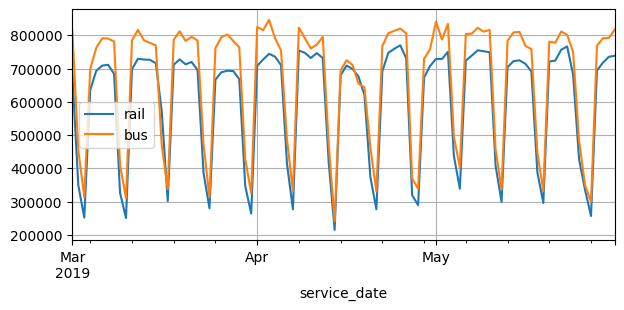

In [314]:
data[['rail', 'bus']][period].plot(grid=True, figsize=(7,3))

### First let's make the data stationary

<AxesSubplot: xlabel='service_date'>

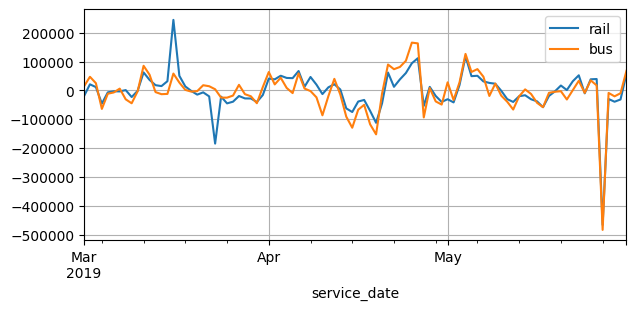

In [315]:
data[['rail', 'bus']].diff(7)[period].plot(grid=True, figsize=(7,3))

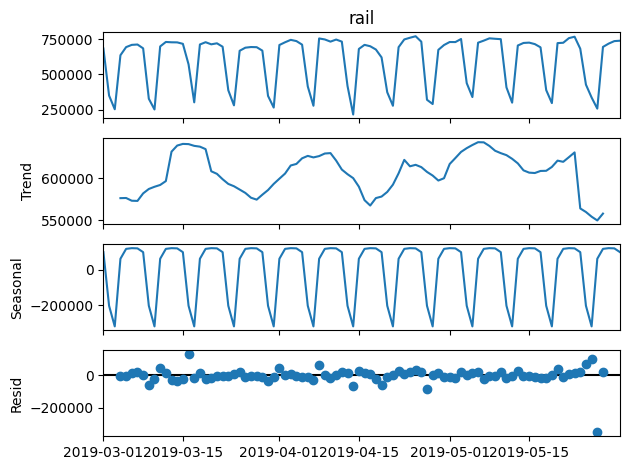

In [319]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(data['rail'][period])
decomposition.plot()
plt.show()

### There is no trend. Therefore $d=0$
### Also previously we saw that there is a clear weekly seasonality. Thereforce $S=7$

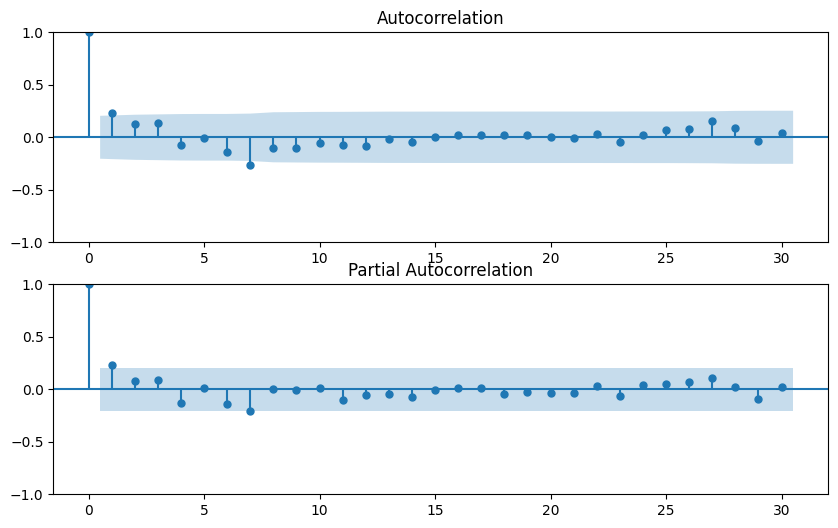

In [324]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
plot_acf(data[['rail']].diff(7)[period], lags=30, ax=ax1)
plot_pacf(data[['rail']].diff(7)[period], lags=30, ax=ax2)
plt.show()

### ACF and PACF are not strongly suggesting values for p and q but they are slightly suggesting $p=1$ and $q=1$ 

### Now we plot ACF and PACF for lags that are multiples of 7 to find P and Q

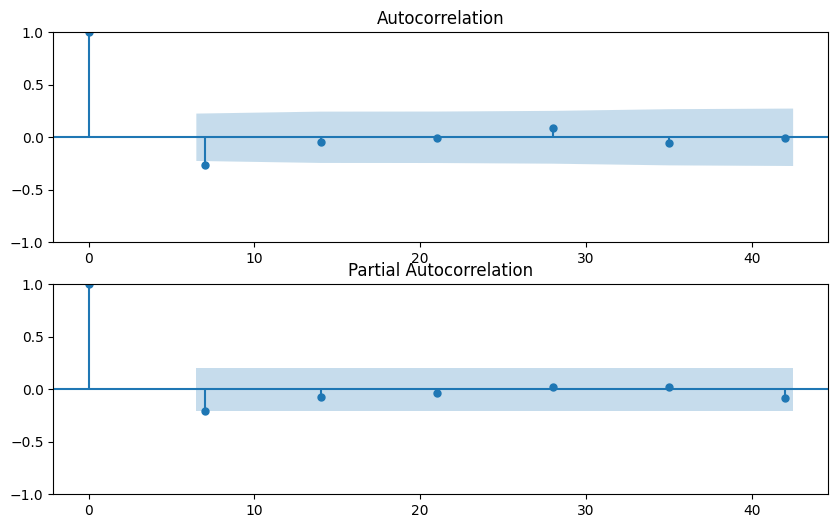

In [327]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
plot_acf(data[['rail']].diff(7)[period], lags=range(0, 45, 7), ax=ax1)
plot_pacf(data[['rail']].diff(7)[period], lags=range(0, 45, 7), ax=ax2)
plt.show()

### Again no strong suggestions for P and Q, but slight suggestion on $P=1, Q=1$ 

### Let's do grid search to find the best values for $p, q, P, Q$ (we already know $d=0, D=1, S=7$)

#### Rideship is lower on the weekends and holidays. Therfore we should use the `day_type` column as an exogenous variable. First we need to transform it by converting letters to digits:

In [ ]:
def transform(x):
    m = {'W':0, 'A':1, 'U':2}
    return m[x]
data["day_type"] = data["day_type"].map(lambda x: transform(x))

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA

origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = data.loc[origin:end_date]["rail"]
rail_and_date_type_series = data.loc[origin:end_date][["rail", 'day_type']]
day_type = data.loc[origin:end_date]["day_type"]

params_dict = {
    'p':[0,1],
    'd':[0],
    'q':[0,1],
    'P':[0,1,2],
    'D':[1],
    'Q':[0,1,2],
}

results = []
for params in tqdm(ParameterGrid(params_dict)):
    y_preds = []
    for today in time_period.shift(-1):
        model = ARIMA(rail_series[origin:today], 
            order=(params['p'], params['d'], params['q']),
            seasonal_order=(params['P'], params['D'], params['Q'], 7),
            exog=day_type[origin:today]
        )
        model = model.fit()
        y_pred = model.forecast(exog=day_type[today + pd.DateOffset(days=1)])[0]
        y_preds.append(y_pred)
    y_preds = pd.Series(y_preds, index=time_period)
    mae = (y_preds - rail_series[time_period]).abs().mean()

    results.append((params, mae))

In [333]:
# Best Params
sorted(results, key=lambda x:x[1])[0]

({'D': 1, 'P': 2, 'Q': 1, 'd': 0, 'p': 1, 'q': 0}, 23972.381050508648)

In [336]:
# creating a model with the best found params
model = ARIMA(rail_series[origin:today],
	order=(1, 0, 0),
	seasonal_order=(2, 1, 1, 7),
	exog=day_type[origin:today]
)
model = model.fit() 

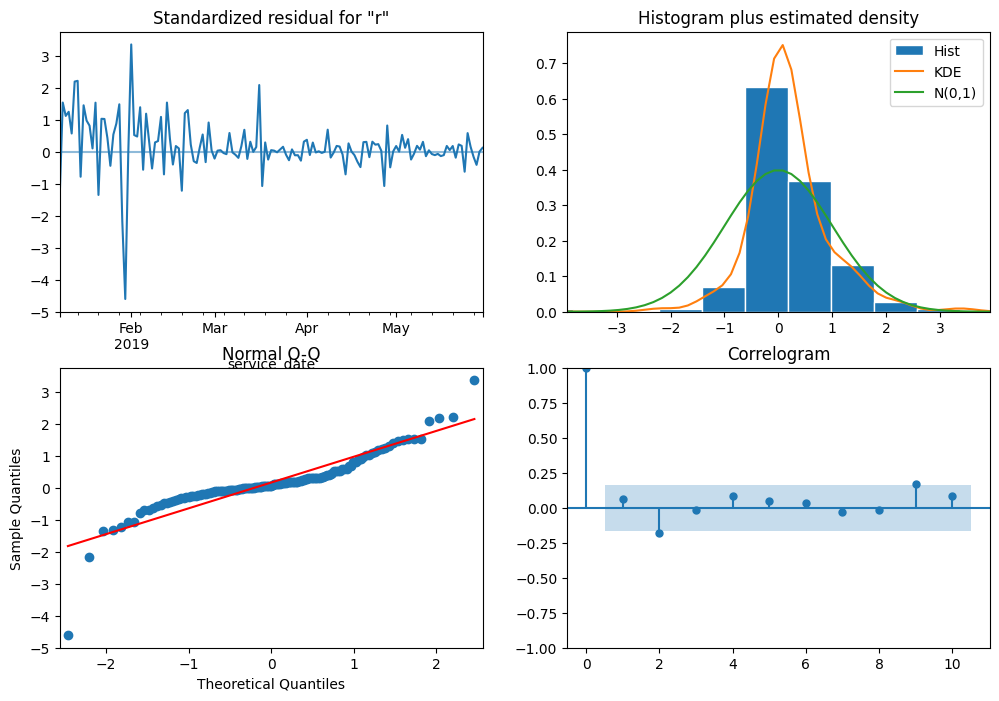

In [337]:
model.plot_diagnostics(figsize=(12,8))  # generates four plots to see if residuals are white noise 
plt.show()

### MAE, MAPE, wMAPE

In [339]:
mae = (y_preds - rail_series[time_period]).abs().mean()
mape = ((y_preds - rail_series[time_period]).abs() / rail_series[time_period]).mean() * 100
wmape = (y_preds - rail_series[time_period]).abs().sum() * 100 / rail_series[time_period].sum()
print(f'MAE: {int(mae)}, MAPE: {round(mape, 2)}%, wMAPE: {round(wmape,2)}%')

MAE: 23972, MAPE: 5.01%, wMAPE: 3.97%
